# Feature extraction from VGG16 model

In [9]:
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

import shutil, pathlib
import keras
import matplotlib.pyplot as plt
import numpy as np
from keras import layers
from keras.utils import image_dataset_from_directory
from google.colab import drive

drive.mount('/content/drive')
# Assuming '800_800' is directly under 'My Drive'. Adjust the path if it's in a subfolder.
new_base_dir = pathlib.Path("/content/drive/My Drive/NeuroGroup8/PrWeek2-3/800_800")

After connecting to Google Drive and ensuring the model has access to our dataset, we can download the VGG16 model and examine its parameters

In [10]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3))
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

Now that everything is downloaded and seems functional, we will adapt our dataset to the VGG input size of 224x224 pixels.

In [11]:
train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size = (224, 224),
    batch_size = 32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size = (224, 224),
    batch_size = 32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size = (224, 224),
    batch_size = 32)

Found 416 files belonging to 4 classes.
Found 92 files belonging to 4 classes.
Found 92 files belonging to 4 classes.


We got the message that all pictures are found within our 4 classes, so we can now extract features from them using the pre-trained VGG16 convolutional base.

In [12]:
def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels = get_features_and_labels(train_dataset)
val_features, val_labels = get_features_and_labels(validation_dataset)
test_features, test_labels = get_features_and_labels(test_dataset)

train_features.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


(416, 7, 7, 512)

With the (7, 7, 512) feature maps extracted from the VGG16 convolutional base, we can now build a new classification model using Keras. This model will consist of a Flatten layer to convert the 3D feature maps into 1D vectors, followed by a Dense layer with 256 units and a Dropout layer for regularization. Finally, a Dense output layer with 4 units (for our 4 classes) and a softmax activation will predict the class probabilities. We will then compile the model and display its summary to verify the architecture.

In [13]:
inputs = keras.Input(shape=(7, 7, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(4, activation="softmax")(x)
model = keras.Model(inputs, outputs)

model.compile(loss="sparse_categorical_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,423,812 (24.50 MB)

 Trainable params: 6,423,812 (24.50 MB)

 Non-trainable params: 0 (0.00 B)

After defining our classification model, we will train it using our extracted features and labels. We'll set up a ModelCheckpoint callback to automatically save the best version of our model (the one with the lowest validation loss) during the training process. This ensures that we retain the model that performs best on unseen data.

In [14]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction.keras",
        save_best_only=True,
        monitor="val_loss")
]

history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.7740 - loss: 21.2916 - val_accuracy: 0.9130 - val_loss: 5.0686
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9880 - loss: 0.2912 - val_accuracy: 0.9348 - val_loss: 1.9288
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9880 - loss: 0.1998 - val_accuracy: 0.9565 - val_loss: 0.5725
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9952 - loss: 0.0844 - val_accuracy: 0.9457 - val_loss: 2.0655
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9639 - loss: 1.2000 - val_accuracy: 0.9565 - val_loss: 2.3630
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9928 - loss: 0.2562 - val_accuracy: 0.9457 - val_loss: 4.0885
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9928 - loss: 0.1977 - val_accuracy: 0.9674 - val_loss: 2.4473
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 6.9365e-06 - val_accuracy: 0.9674 - v

The following graphs display the training and validation accuracy, along with the training and validation loss over the epochs.

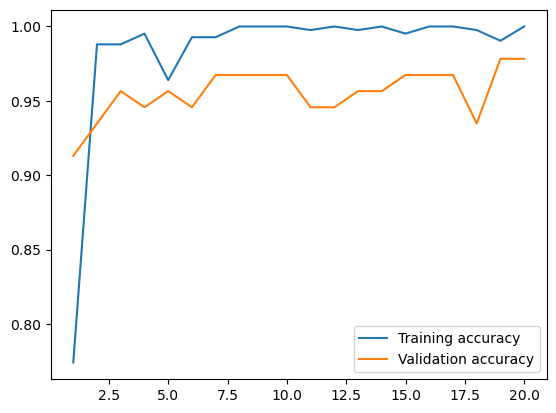

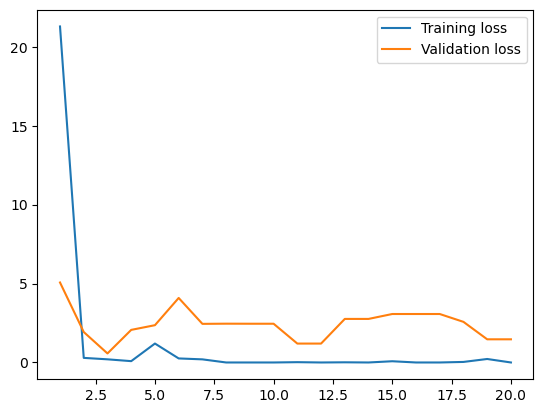

In [15]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = list(range(1, len(accuracy)+1))
plt.plot(epochs, accuracy, label="Training accuracy")
plt.plot(epochs, val_accuracy, label="Validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, label="Training loss")
plt.plot(epochs, val_loss, label="Validation loss")
plt.legend()
plt.show()

As you can see, the model achieved very good results, and it's possible that even fewer epochs (perhaps around 10) could have been sufficient to reach a similar performance level.

In [16]:
test_model = keras.models.load_model("feature_extraction.keras")
test_loss, test_acc = test_model.evaluate(test_features, test_labels)
print(f"Test accuracy: {test_acc:.3f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 0.9783 - loss: 0.9058
Test accuracy: 0.978


--- Visualizing Errors ---
Gathering images for visualization...
Predicting outcomes...


2025-11-19 19:51:25.225273: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Found 2 errors.


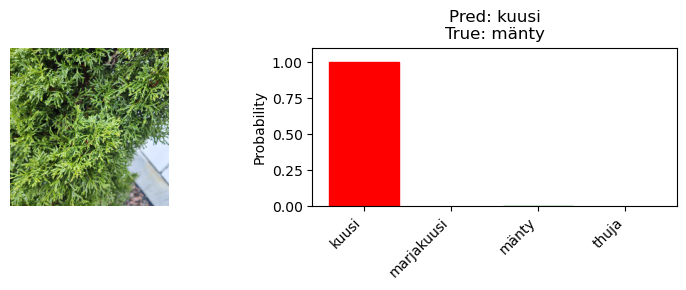

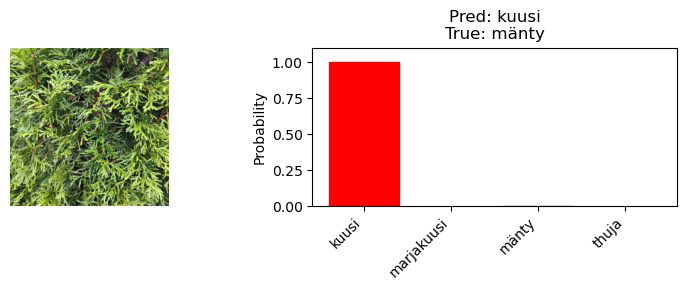

In [17]:
import numpy as np
import matplotlib.pyplot as plt

print("--- Visualizing Errors ---")

# 1. Määritellään luokat (varmista että nämä ovat oikeat)
# Jos sinulla on train_dataset muistissa, voit käyttää: class_names = train_dataset.class_names
if 'train_dataset' in locals():
    class_names = train_dataset.class_names
else:
    # Muuten määritellään käsin (TARKISTA JÄRJESTYS!)
    class_names = ['kuusi', 'marjakuusi', 'mänty', 'tuija']

# 2. Kerätään kaikki testikuvat listaksi, jotta voimme hakea niitä indeksillä
# TÄRKEÄÄ: Tämä olettaa, että test_dataset on ladattu shuffle=False -asetuksella!
print("Gathering images for visualization...")
all_test_images = []
for img_batch, _ in test_dataset:
    all_test_images.append(img_batch.numpy())
all_test_images = np.concatenate(all_test_images)

# 3. Tehdään ennusteet käyttäen `test_features` (koska malli on koulutettu piirteillä)
# Käytetään 'test_model' muuttujaa, joka on ladattu notebookissasi
print("Predicting outcomes...")
predictions = test_model.predict(test_features, verbose=0)
pred_indices = np.argmax(predictions, axis=1)

# 4. Varmistetaan labelien muoto
if test_labels.ndim > 1:
    true_indices = np.argmax(test_labels, axis=1)
else:
    true_indices = test_labels.astype(int)

# 5. Etsitään virheet
error_indices = np.where(pred_indices != true_indices)[0]
print(f"Found {len(error_indices)} errors.")

# 6. Piirretään virheet
num_errors_to_show = min(10, len(error_indices))

for k in range(num_errors_to_show):
    idx = error_indices[k]

    plt.figure(figsize=(8, 3))

    # --- KUVA ---
    plt.subplot(1, 2, 1)

    # VGG16 preprocess_input muuttaa värit (esim. BGR ja negatiiviset arvot).
    # Tehdään nopea normalisointi (min-max scaling) jotta kuva näyttää järkevältä ihmissilmälle.
    img = all_test_images[idx]
    display_img = (img - img.min()) / (img.max() - img.min())

    plt.imshow(display_img)
    plt.axis('off')

    # --- ENNUSTE ---
    plt.subplot(1, 2, 2)
    probs = predictions[idx]

    bars = plt.bar(np.arange(len(class_names)), probs)
    plt.xticks(np.arange(len(class_names)), class_names, rotation=45, ha='right')

    # Värit: Punainen väärälle, Vihreä oikealle
    bars[pred_indices[idx]].set_color('red')
    bars[true_indices[idx]].set_color('green')

    pred_label = class_names[pred_indices[idx]]
    true_label = class_names[true_indices[idx]]

    plt.ylabel("Probability")
    plt.title(f"Pred: {pred_label}\nTrue: {true_label}")
    plt.ylim(0, 1.1)

    plt.tight_layout()
    plt.show()